In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.ensemble import AdaBoostRegressor

In [397]:
data = pd.read_csv("forestfires.csv")

data.describe()
data.corr()
print(data.info())
data.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None


0

In [343]:
data.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [398]:
months_to_remove = ['nov', 'may', 'jan']

data = data.drop(data[data['month'].isin(months_to_remove)].index, axis=0, inplace=False)

In [334]:
data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [408]:
data['Logarea'] = np.log(data['area'] + 1)
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Logarea
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,4.671875,4.302734,90.836523,111.835547,552.363477,9.083984,18.972852,44.050781,4.022852,0.021875,12.897598,1.114696
std,2.320198,1.232372,4.489480,63.597107,245.120680,4.533396,5.753180,15.977888,1.794088,0.297396,63.946316,1.397215
min,1.000000,2.000000,50.400000,2.400000,7.900000,0.400000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.300000,70.950000,448.375000,6.575000,15.675000,32.750000,2.700000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.350000,664.500000,8.400000,19.300000,41.500000,4.000000,0.000000,0.545000,0.435019
75%,7.000000,5.000000,92.900000,142.400000,714.000000,11.000000,22.800000,53.000000,5.025000,0.000000,6.572500,2.024523
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,99.000000,9.400000,6.400000,1090.840000,6.995620


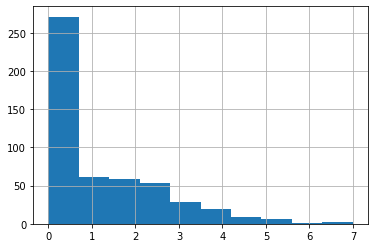

In [409]:
data['Logarea'].hist()

In [410]:
labelencoder = LabelEncoder()
data['month'] = labelencoder.fit_transform(data['month'])
data['day'] = labelencoder.fit_transform(data['day'])

In [279]:
data.corr()['Logarea'].abs().sort_values()

ISI        0.017734
rain       0.023253
FFMC       0.025196
month      0.033163
day        0.035029
RH         0.042128
Y          0.042705
temp       0.043728
X          0.063062
DMC        0.063161
DC         0.063409
wind       0.065307
area       0.524626
Logarea    1.000000
Name: Logarea, dtype: float64

In [280]:
data.dtypes

X            int64
Y            int64
month        int64
day          int64
FFMC       float64
DMC        float64
DC         float64
ISI        float64
temp       float64
RH           int64
wind       float64
rain       float64
area       float64
Logarea    float64
dtype: object

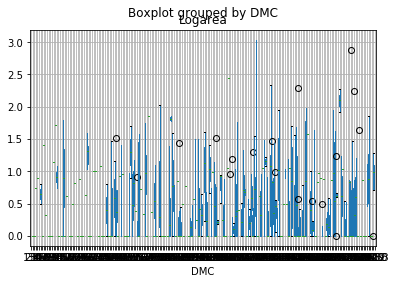

In [25]:
data.boxplot(column='Logarea',by='DMC')

In [433]:
features = data.drop(['area', 'Logarea', 'X', 'Y', 'month', 'day', 'FFMC', 'wind', 'rain', 'Logarea_bins'], axis=1)
features

,DMC,DC,ISI,temp,RH
0,26.2,94.3,5.1,8.2,51
1,35.4,669.1,6.7,18.0,33
2,43.7,686.9,6.7,14.6,33
3,33.3,77.5,9.0,8.3,97
4,51.3,102.2,9.6,11.4,99
...,...,...,...,...,...
511,56.7,665.6,1.9,27.8,35
512,56.7,665.6,1.9,27.8,32
513,56.7,665.6,1.9,21.9,71
514,56.7,665.6,1.9,21.2,70


In [414]:
outputs = data['Logarea']
outputs

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
511    0.000000
512    2.006871
513    4.012592
514    2.498152
515    0.000000
Name: Logarea, Length: 512, dtype: float64

In [434]:
data['Logarea_bins'] = pd.cut(data['Logarea'], bins=[0, 1, 2, 3, 4, 8], include_lowest=True, 
                                 labels=['0-1', '1-2', '2-3', '3-4', '>4'])
data.Logarea_bins.value_counts(sort=False)

0-1    295
1-2     84
2-3     74
3-4     36
>4      23
Name: Logarea_bins, dtype: int64

In [435]:
sss = StratifiedShuffleSplit(random_state=0, n_splits=1, test_size=0.3)

for train_index, test_index in sss.split(data.values, data.Logarea_bins.values):
    X_train = features.iloc[train_index]
    y_train = outputs.iloc[train_index]
    X_test = features.iloc[test_index]
    y_test = outputs.iloc[test_index]

In [436]:
X_train

,DMC,DC,ISI,temp,RH
248,157.3,666.7,13.5,28.7,28
19,27.4,97.1,5.1,9.3,44
356,99.0,745.3,9.6,20.8,35
391,91.3,738.1,7.2,20.7,46
306,84.1,714.3,5.7,17.1,53
...,...,...,...,...,...
297,89.5,290.8,6.4,15.4,45
351,99.0,745.3,9.6,15.4,53
185,129.5,692.6,7.0,17.6,46
377,231.1,715.1,8.4,21.9,42


In [419]:
X_train.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain'],
      dtype='object')

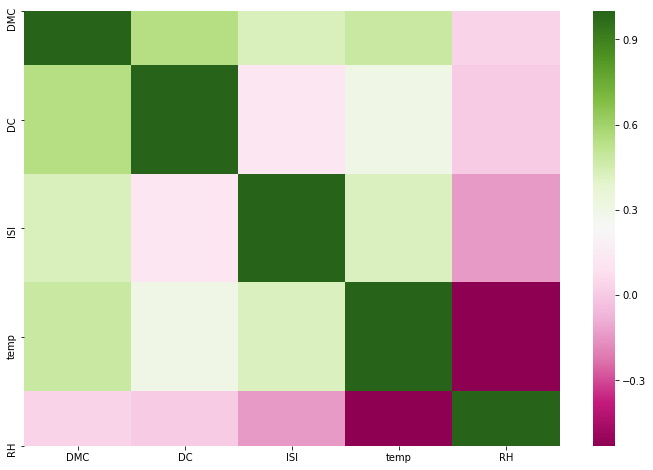

In [437]:
corr_matrix = X_train.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='PiYG')

In [420]:
model = DecisionTreeRegressor()
rfe = RFECV(model, step=0.1, cv=10)
fit = rfe.fit(X_train, y_train)

print("Number of Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_) 

Number of Features:  1
Selected Features:  [False False False False False False False False  True False False False]
Feature Ranking:  [ 6  9 11 10  8  5  3  4  1  2  7 12]


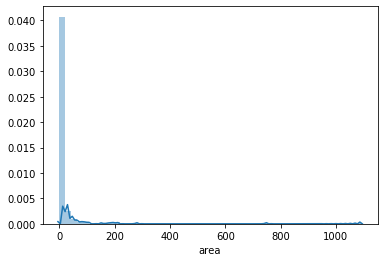

In [381]:
sns.distplot(data['area'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a274b7b00>,
      dtype=object)

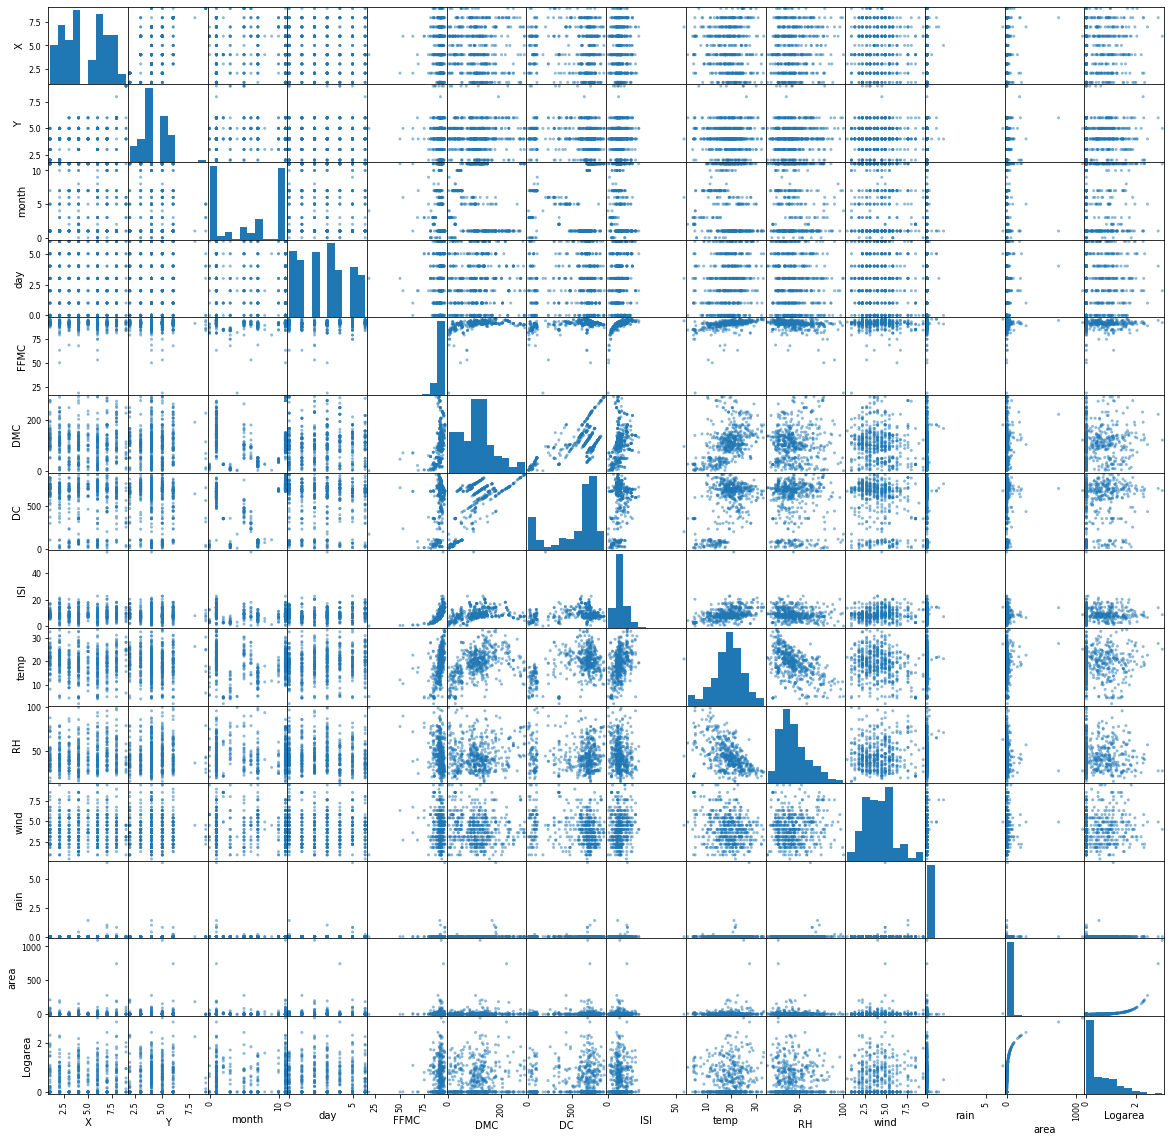

In [15]:
pd.plotting.scatter_matrix(data, alpha=0.5, figsize=(20,20))

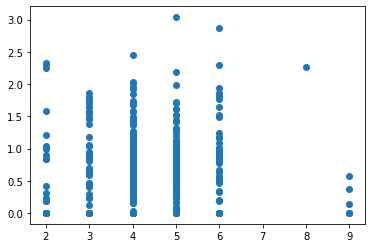

In [298]:
plt.scatter(data['Y'], data['Logarea'])

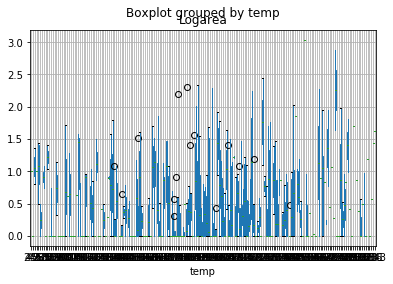

In [301]:
data.boxplot(column='Logarea', by='temp')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2bff3c18>,
      dtype=object)

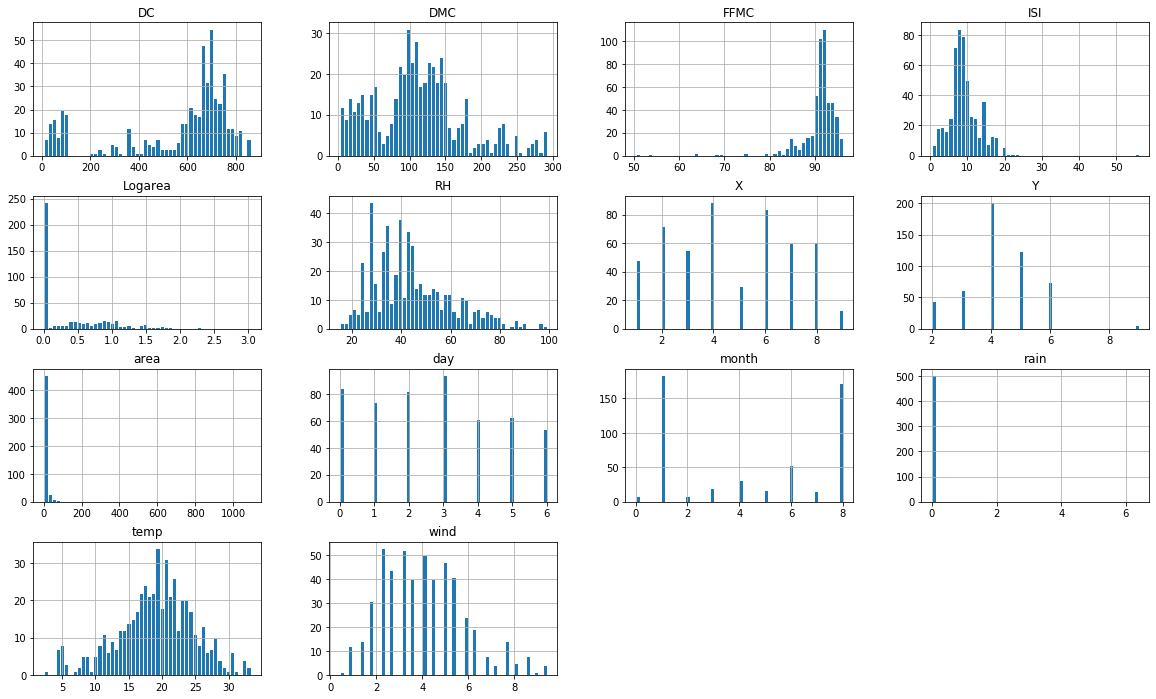

In [287]:
data.hist(bins=50, figsize=(20,12), ec='w')

In [454]:
dtr = DecisionTreeRegressor(random_state=0, max_depth=2, max_features=4)
dtr.fit(X_train, y_train)
y_predict = np.e ** dtr.predict(X_test) - 1
y_true = np.e ** y_test - 1
y_true
mse = mean_squared_error(y_true, y_predict)
rmse = np.sqrt(mse)
rmse

91.22475430991659

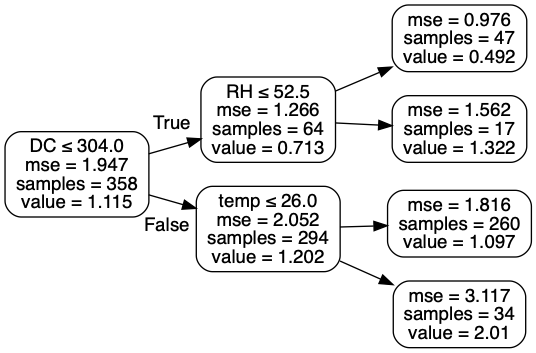

In [453]:
dtr = DecisionTreeRegressor(random_state=0, max_depth=2, max_features=4).fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, special_characters=True, filled=False, rounded=True, 
                rotate=True, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Decision Tree Regressor.png')
Image(graph.create_png())

In [ ]:
dtr.predict

In [125]:
dtr.n_features_

12

In [126]:
dtr.feature_importances_

array([1.21580175e-03, 4.85318661e-03, 4.04916378e-03, 5.87782604e-05,
       5.66391966e-01, 7.21205063e-03, 3.97793499e-02, 2.60146011e-01,
       5.66176917e-02, 4.75624837e-02, 1.21135167e-02, 0.00000000e+00])

In [78]:
dtr.get_depth()

23

In [79]:
dtr.get_n_leaves()

334

In [80]:
dtr.max_features_

12

In [451]:
param_grid_dtr = {
    'max_depth': [None, 2, 3, 4, 5, 6, 7],
    'max_features': [1, 2, 3, 4, 5],
    'random_state': [0]
}

In [452]:
dtr = DecisionTreeRegressor()
dtrc = GridSearchCV(dtr, param_grid_dtr, scoring='neg_mean_absolute_error', cv=10)
dtrc.fit(X_train, y_train)
print(dtrc.best_score_)
print(dtrc.best_params_)

-1.1409883763305075
{'max_depth': 2, 'max_features': 4, 'random_state': 0}


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [445]:
param_grid_abr = {
    'n_estimators': [10, 15, 20, 35, 50, 65],
    'learning_rate': [0.1, 0.01, 0.0025, 0.001],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [0]
}

In [446]:
abr = AdaBoostRegressor()
abrc = GridSearchCV(abr, param_grid_abr, scoring='neg_mean_absolute_error', cv=10)
abrc.fit(X_train, y_train)
print(abrc.best_score_)
print(abrc.best_params_)

-1.1179360551984407
{'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 20, 'random_state': 0}


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [447]:
abr = AdaBoostRegressor(n_estimators=20, learning_rate=0.001, loss='exponential', random_state=0)

abr.fit(X_train, y_train)

y_predict = np.e ** abr.predict(X_test) - 1
y_true = np.e ** y_test - 1
y_true
mse = mean_squared_error(y_true, y_predict)
rmse = np.sqrt(mse)
print('RMSE: ', rmse)

RMSE:  91.24611111671672


In [448]:
abr.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=209652396, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=631419855, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_frac

In [129]:
abr.feature_importances_

array([0.04105412, 0.03753561, 0.00743643, 0.06294811, 0.02364855,
       0.18649439, 0.0202613 , 0.00177132, 0.55951081, 0.04763311,
       0.01170626, 0.        ])

In [224]:
def get_nll(y_true, y_predict):
    prediction_mean = np.mean(y_predict)
    prediction_variance = np.var(y_predict)
    return np.log(2 * np.pi * prediction_variance) / 2 + \
            np.sum((y_true - prediction_mean) ** 2) / (2 * prediction_variance)


In [392]:
a = np.array([4, 2, 1, 1, 1])
b = np.array([4, 2, 1, 1, 1])

print(get_nll(a, b))
print(log_loss(a, b))

3.572680883078653


ValueError: y_true and y_pred contain different number of classes 3, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 4]

## a = np.array([3, 2, 1, 1, 1])

a ** 2